In [3]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# EDA

## Load data

In [4]:
train = pd.read_csv('G:\\Program_File\\Python\\SIC\\project\\data\\train.csv')
test = pd.read_csv('G:\\Program_File\\Python\\SIC\\project\\data\\test.csv')
test_y = pd.read_csv("G:\\Program_File\\Python\\SIC\\project\\data\\test_labels.csv")

## Data analyst

In [5]:
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [6]:
train.describe()

toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

In [7]:
test.head()

id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

In [8]:
train.shape

(159571, 8)

In [9]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

Dữ liệu có 159571 hàng và 8 đặc trưng là ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'.]

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

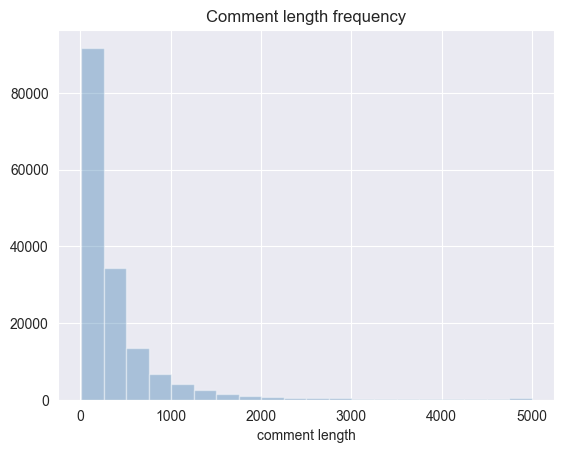

In [10]:
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")
plt.title('Comment length frequency')
plt.xlabel('comment length')
plt.savefig('Comment length frequency')

Ta thấy rằng đa số comment thì chỉ có độ dài nằm trong khoảng 1000 từ.

In [11]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()
label_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

<Axes: title={'center': 'Labels Frequency'}>

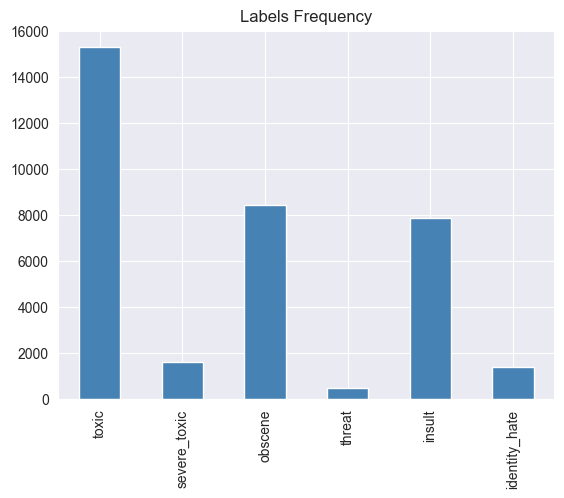

In [12]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue') #label_count.plot.bar()

Ta thấy rằng trong tổng số bình luận tiêu cực, thì số bình luận được gán nhẵn là 'toxic' sẽ có số lượng nhiều nhất. Các bình luận được gán nhắn là 'severe_toxic', 'threat' và 'identity hate' thì rất ít.

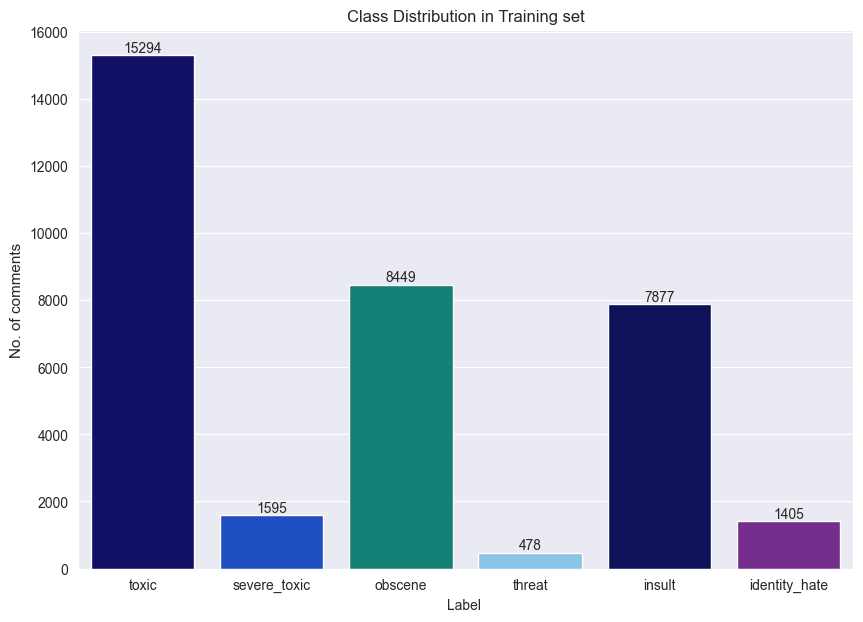

In [13]:
colors_ = ["deep blue","blue", "teal", "lightblue","darkblue","purple"]

palette= sns.xkcd_palette(colors_)

x = label_count

plt.figure(figsize=(10,7))

ax= sns.barplot(x=x.index, y=x.values,palette=palette)
plt.title("Class Distribution in Training set")
plt.xlabel('Label ')
plt.ylabel('No. of comments', fontsize=11)

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.savefig("Class Distribution in Training set")

Biểu đồ trên miêu tả rõ hơn số lượng của các bình luận ứng với mỗi nhãn.

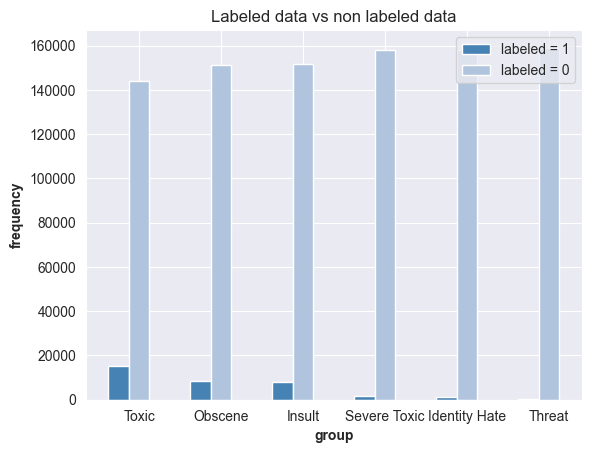

In [14]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.title('Labeled data vs non labeled data')
plt.xlabel('group', fontweight='bold')
plt.ylabel('frequency', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.savefig('Labeled data vs non labeled data')

Xét trên từng nhãn cụ thể, thì số bình luận được đánh số là 1 ít hơn số bình luận được đánh số là 0 nhiều lần. Nguyên nhân là do số bình luận tiêu cực ở trên Wikipedia là khá hiếm.

Ta cùng thử xem qua một bình luận sạch.

In [15]:
# example of clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Và bình luận toxic

In [16]:
# example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

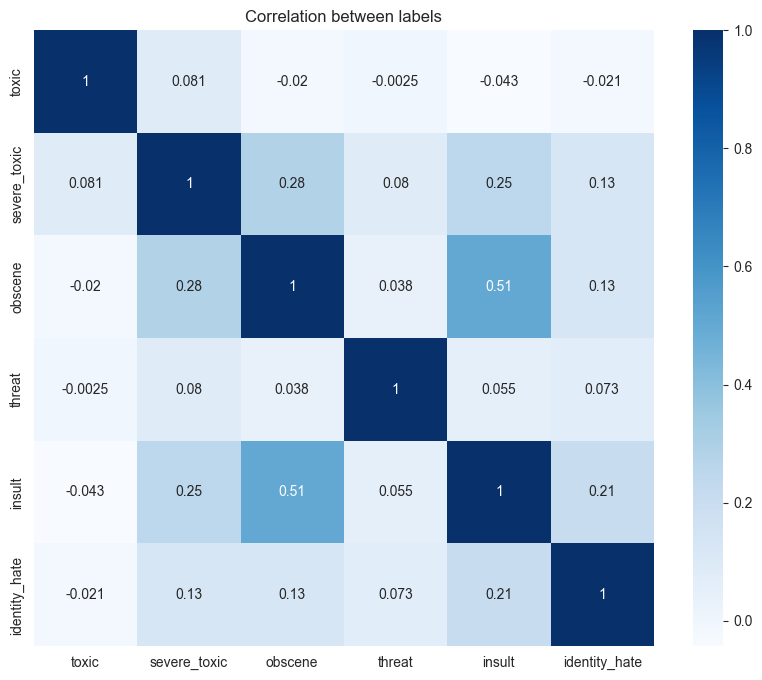

In [17]:
# Cross correlation matrix across labels
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")
plt.title('Correlation between labels')
plt.savefig('Correlation between labels')

Dựa vào ma trận tương quan thì ta thấy hệ số tương quan Pearson giữa cột 'obscene' và 'insult' là khá cao. Nghĩa là những bình luận thô tục thì thường dễ có khả năng cũng mang tính xúc phạm. Thoạt nhìn ban đầu ta đã nghĩ rằng hệ số tương quan của cột 'severe_toxic' với 'toxic' phải cao do một bình luận được gán nhắn là 'severe_toxic' thì nó cũng được xếp vào mục 'toxic'. Nhưng điều ngược lại chưa chắc đúng, do một bình luận toxic có thể toxic ở mức độ nhẹ hơn, nên chưa chắc nó đã được gán nhãn là 'severe_toxic'. Hơn nữa số lượng bình luận 'toxic' lại nhiều hơn số lượng bình luận 'severe_toxic' nhiều lần theo như trên biểu đồ cột ở trên. Đó là lí do vì sao hệ số tương quan của hai cột khá thấp. 

Ta sẽ dùng WordCloud để trực quan hóa số từ xuất hiện nhiều nhất ứng với mỗi cột.

In [18]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train[train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

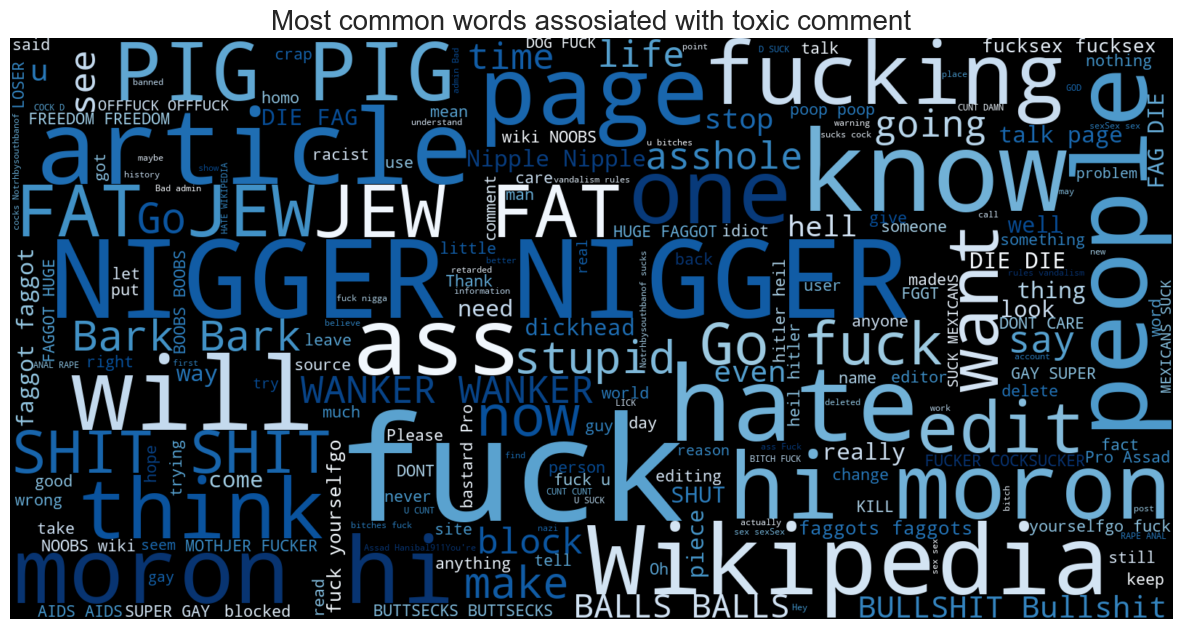

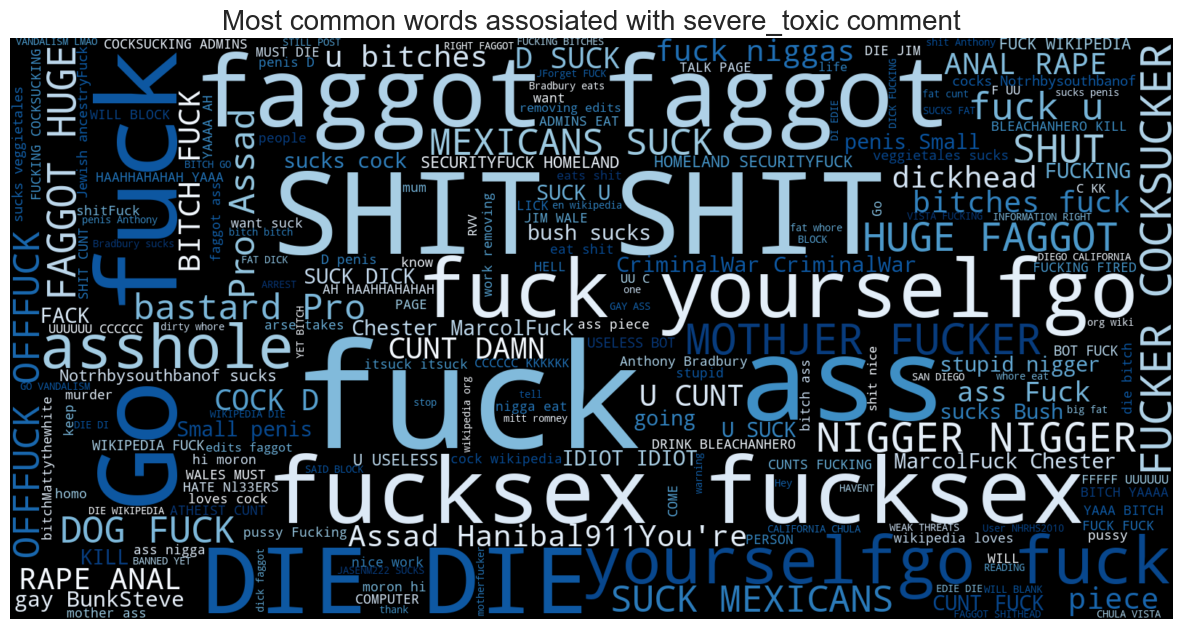

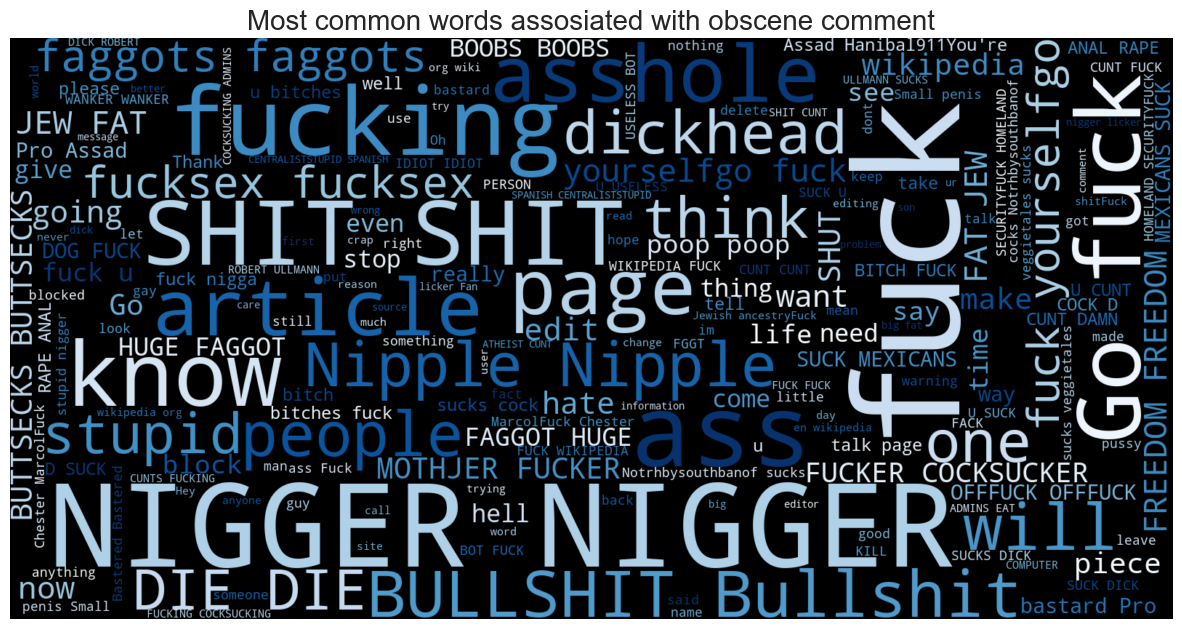

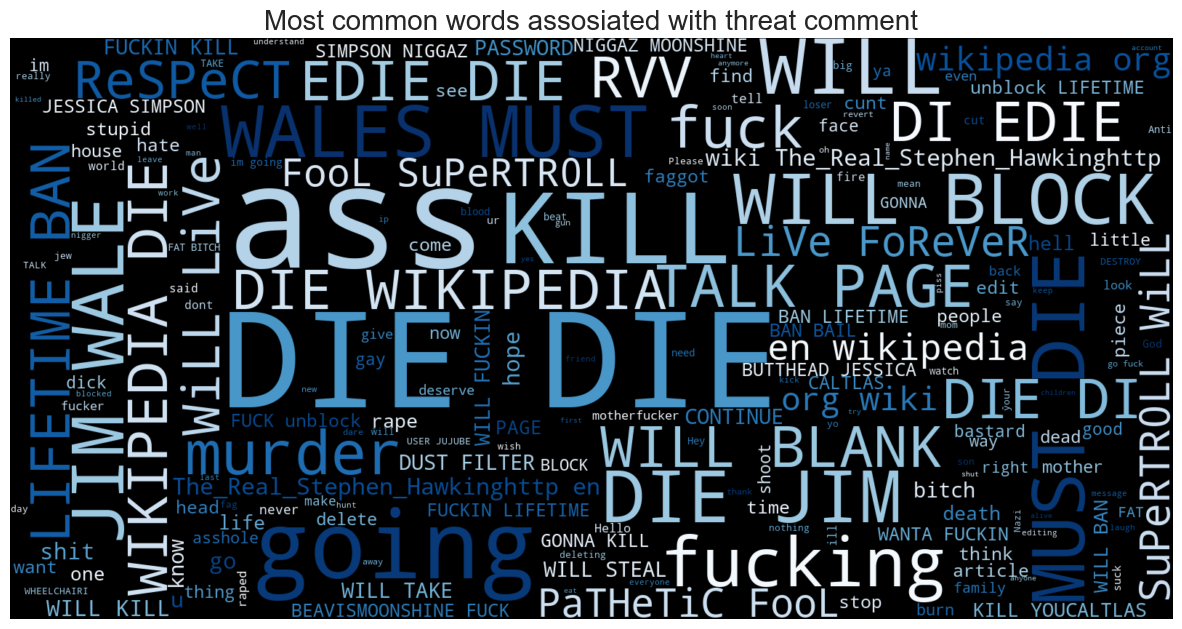

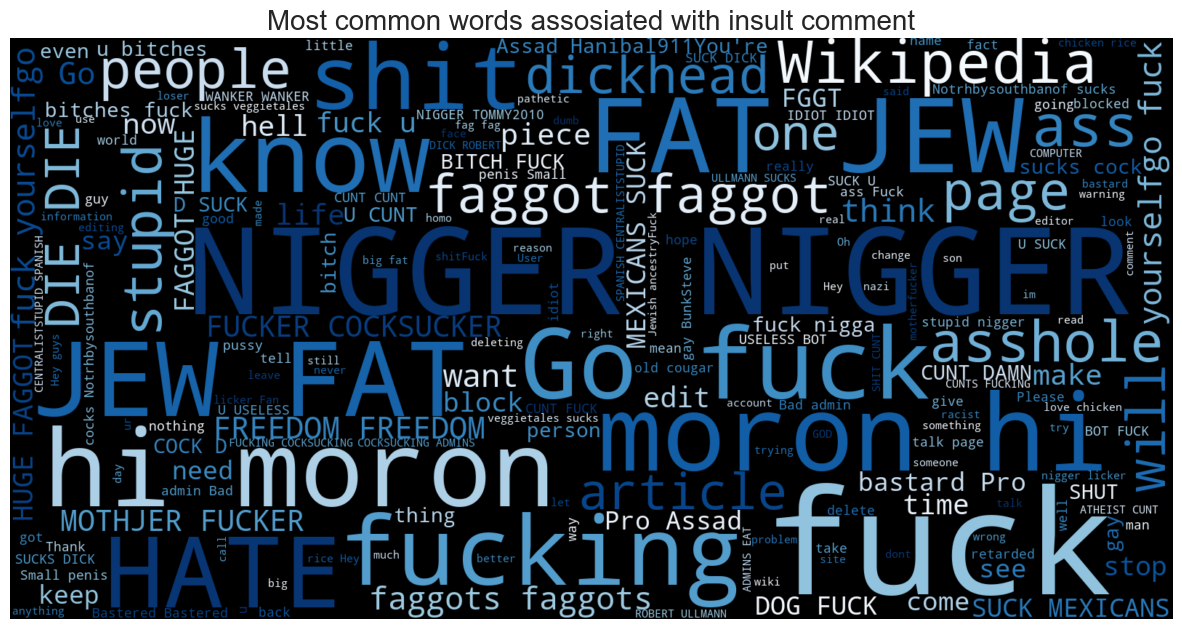

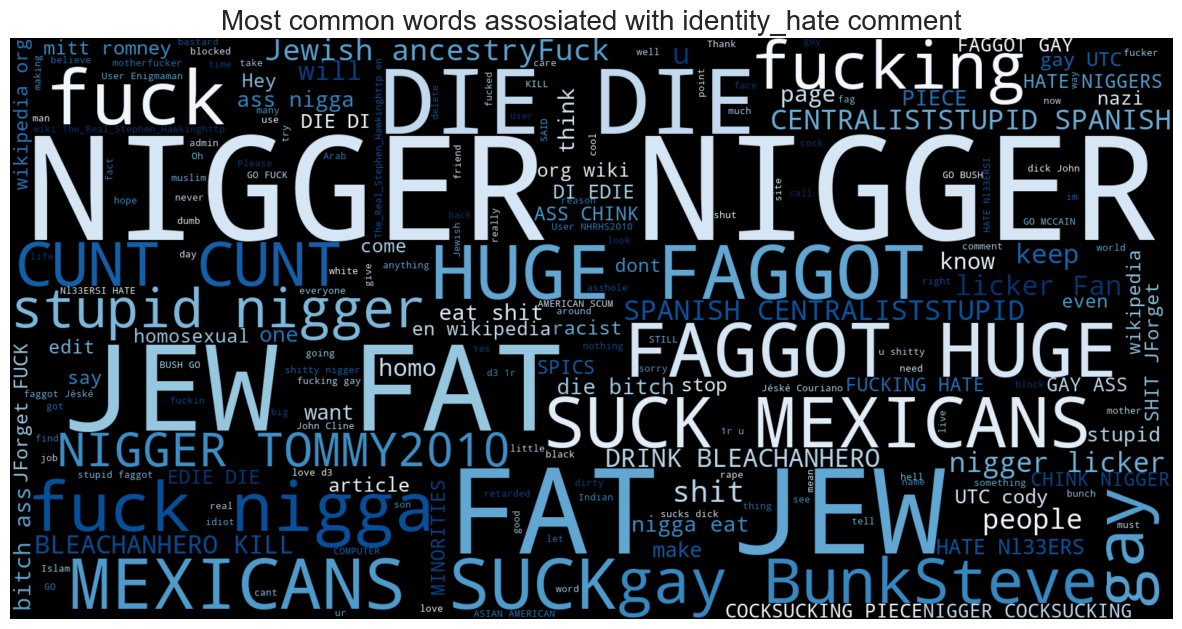

In [19]:
for feature in train.columns[2:]:
    W_Cloud(feature)

In [20]:
def get_word_cnt(tokenizer):
    word_cnt = [(k, v) for k, v in zip(tokenizer.word_counts.keys(), 
                                       tokenizer.word_counts.values())]
    word_cnt.sort(key = lambda tup: tup[1], reverse=True)
    stopWords = set(stopwords.words('english'))
    word_cnt = [tup for tup in word_cnt if tup[0] not in stopWords]
    return word_cnt

def word_plot(word_cnt, num_words, title):
    plt.figure(title, figsize=(24, 12))
    plt.suptitle(title, fontsize=40)
    sns.barplot(x= [tup[0] for tup in word_cnt[0:num_words]], 
                y = [tup[1] for tup in word_cnt[0:num_words]])
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, rotation=35, ha='right')
    plt.show()

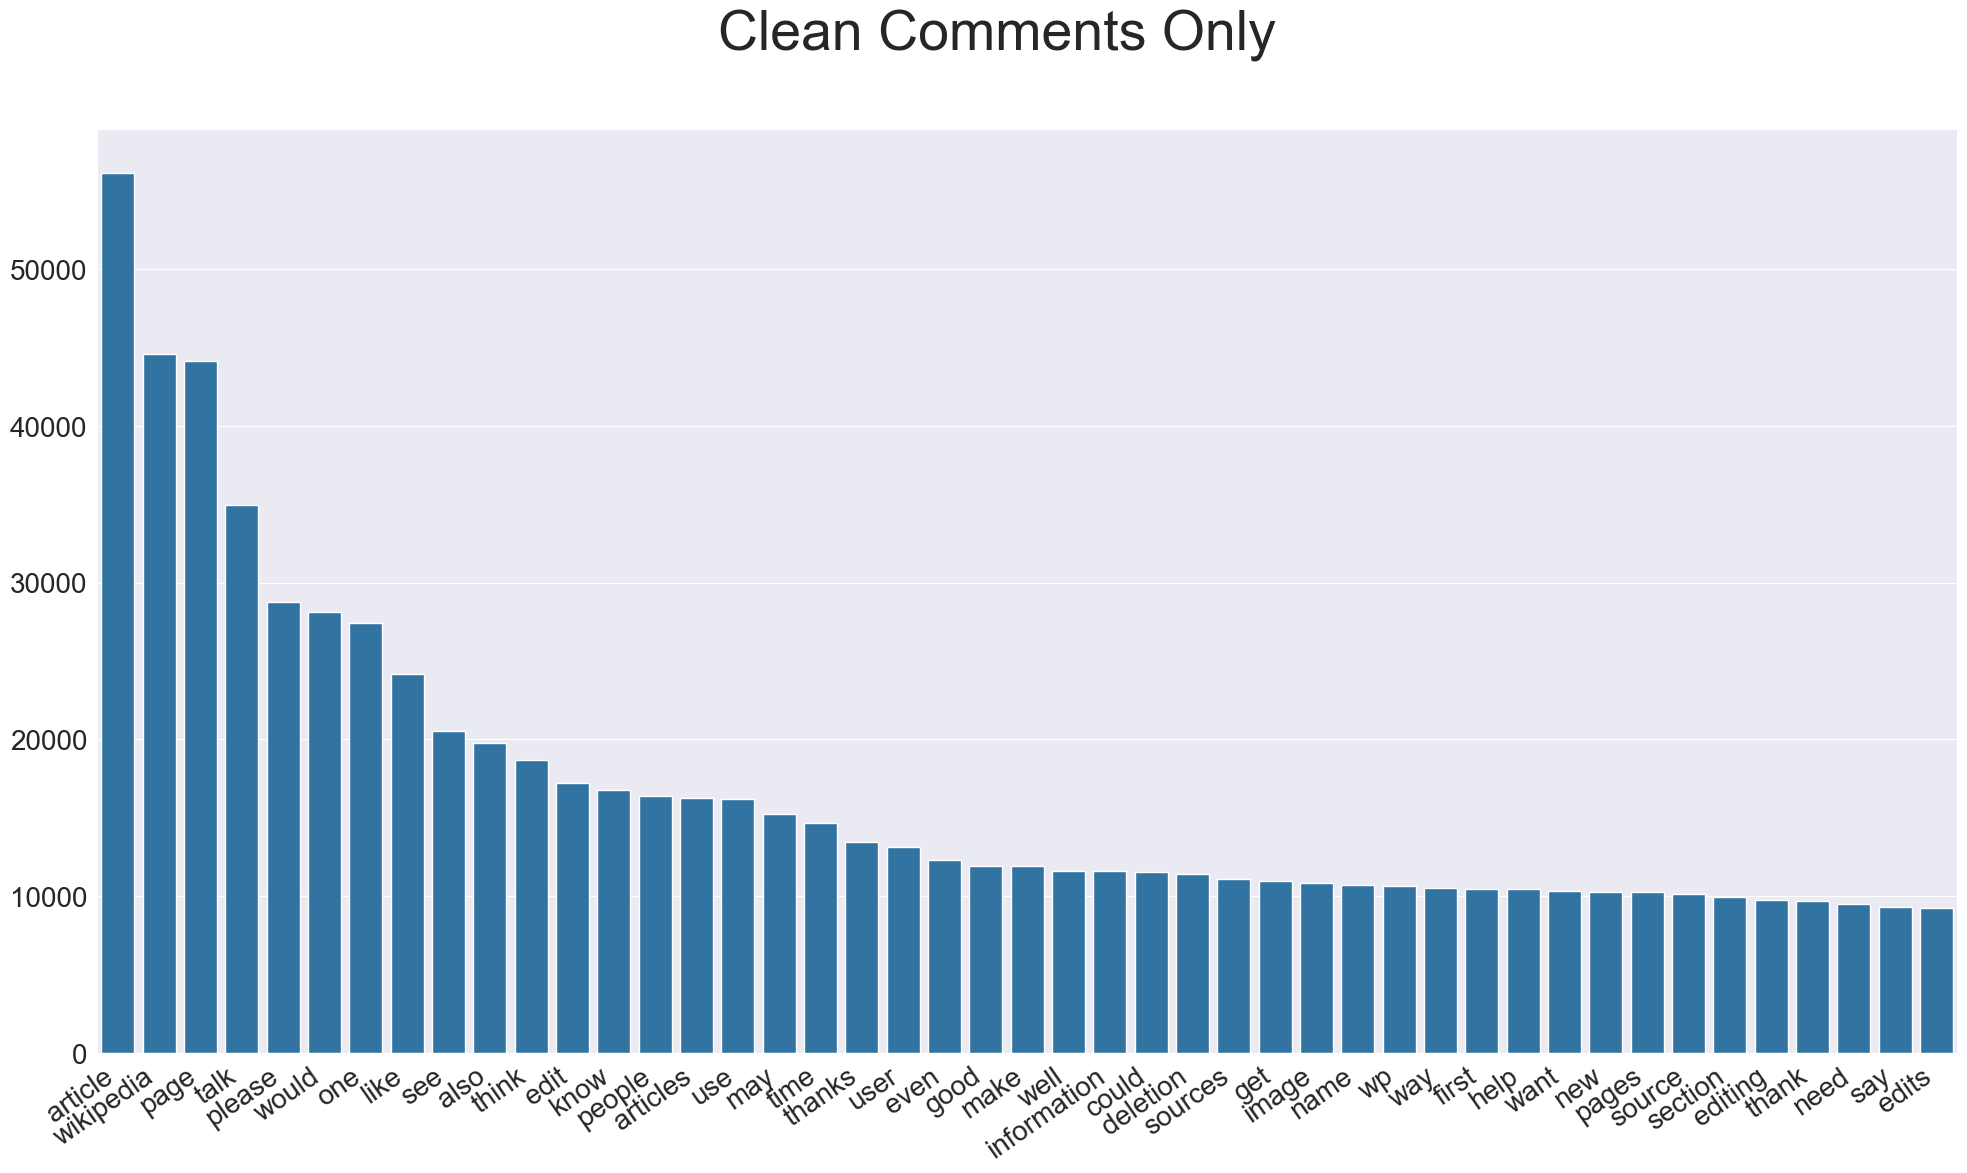

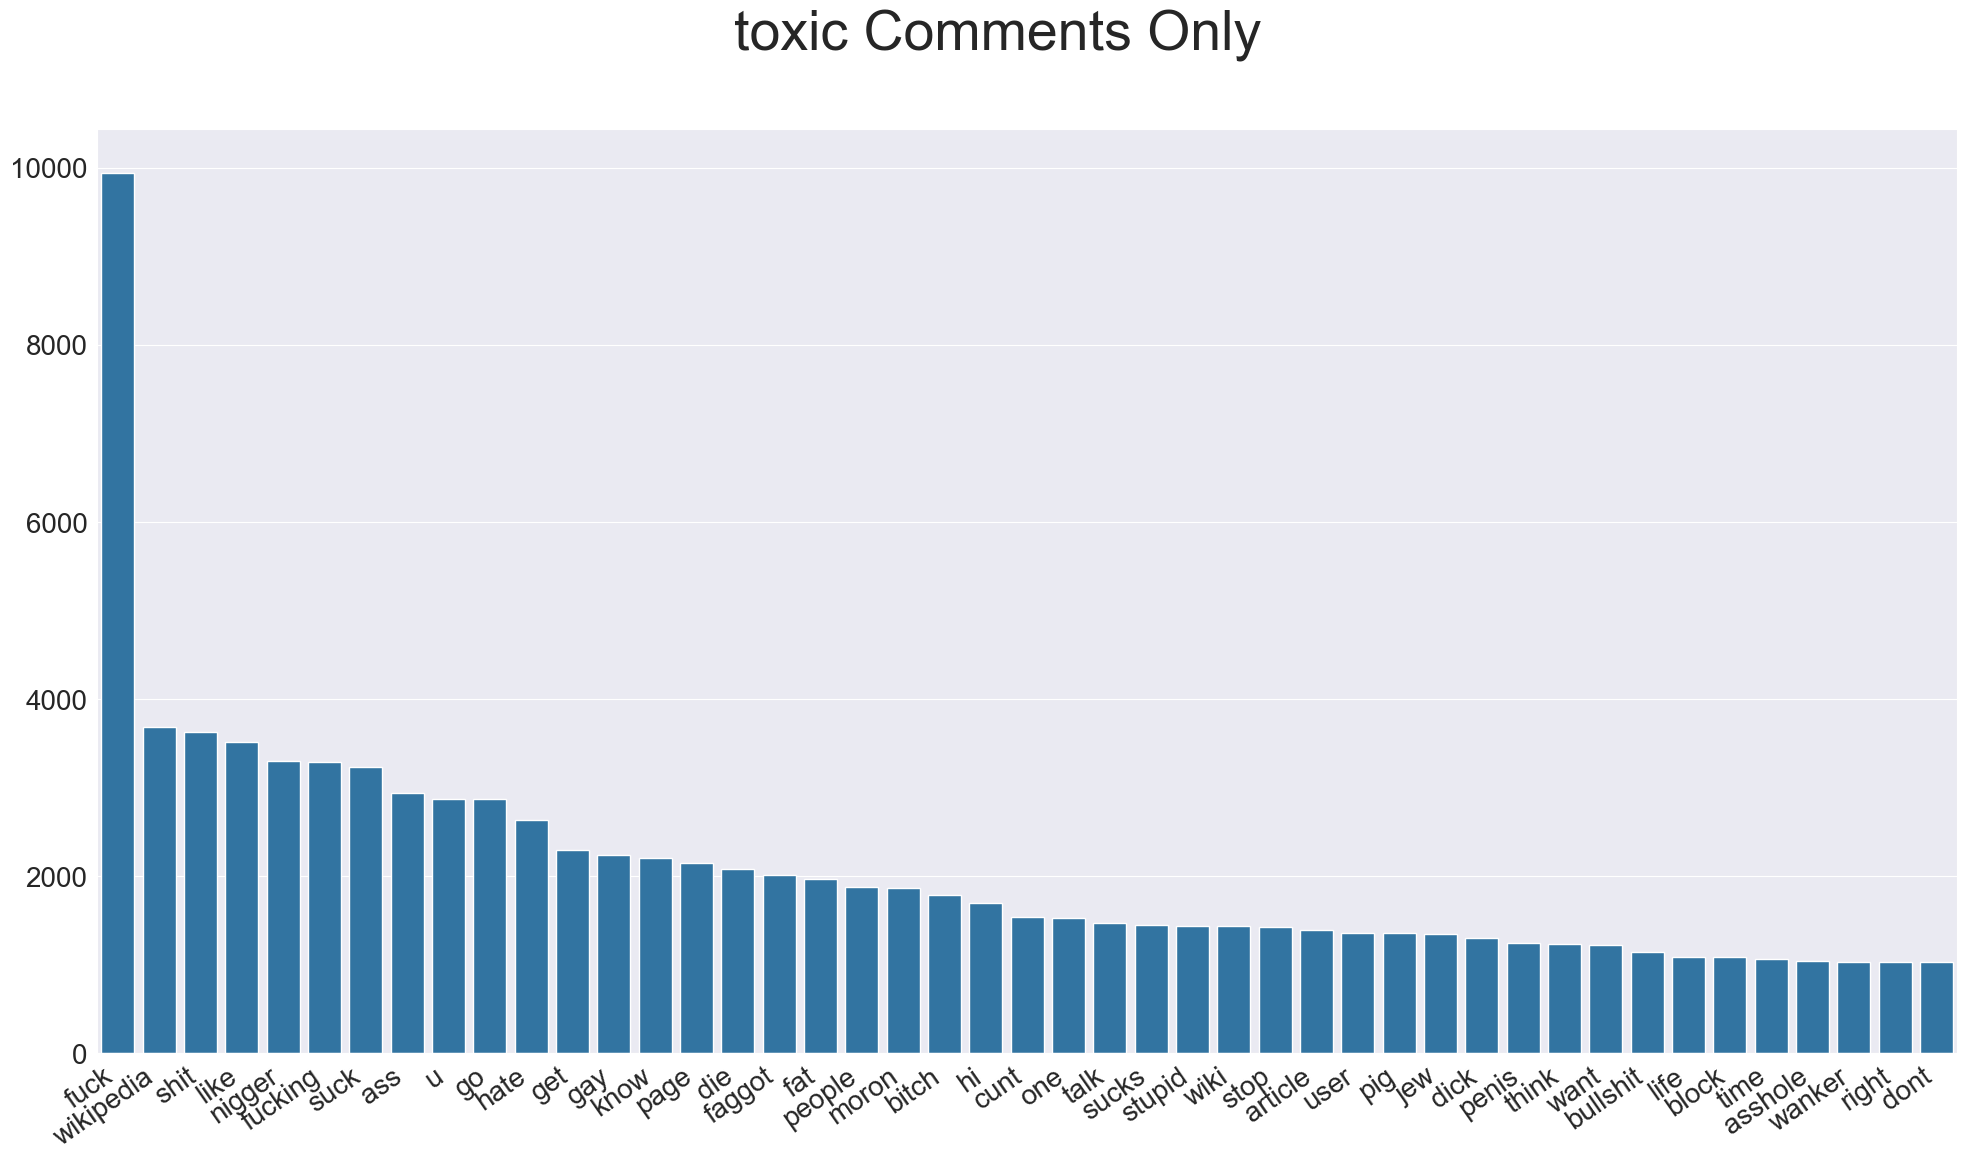

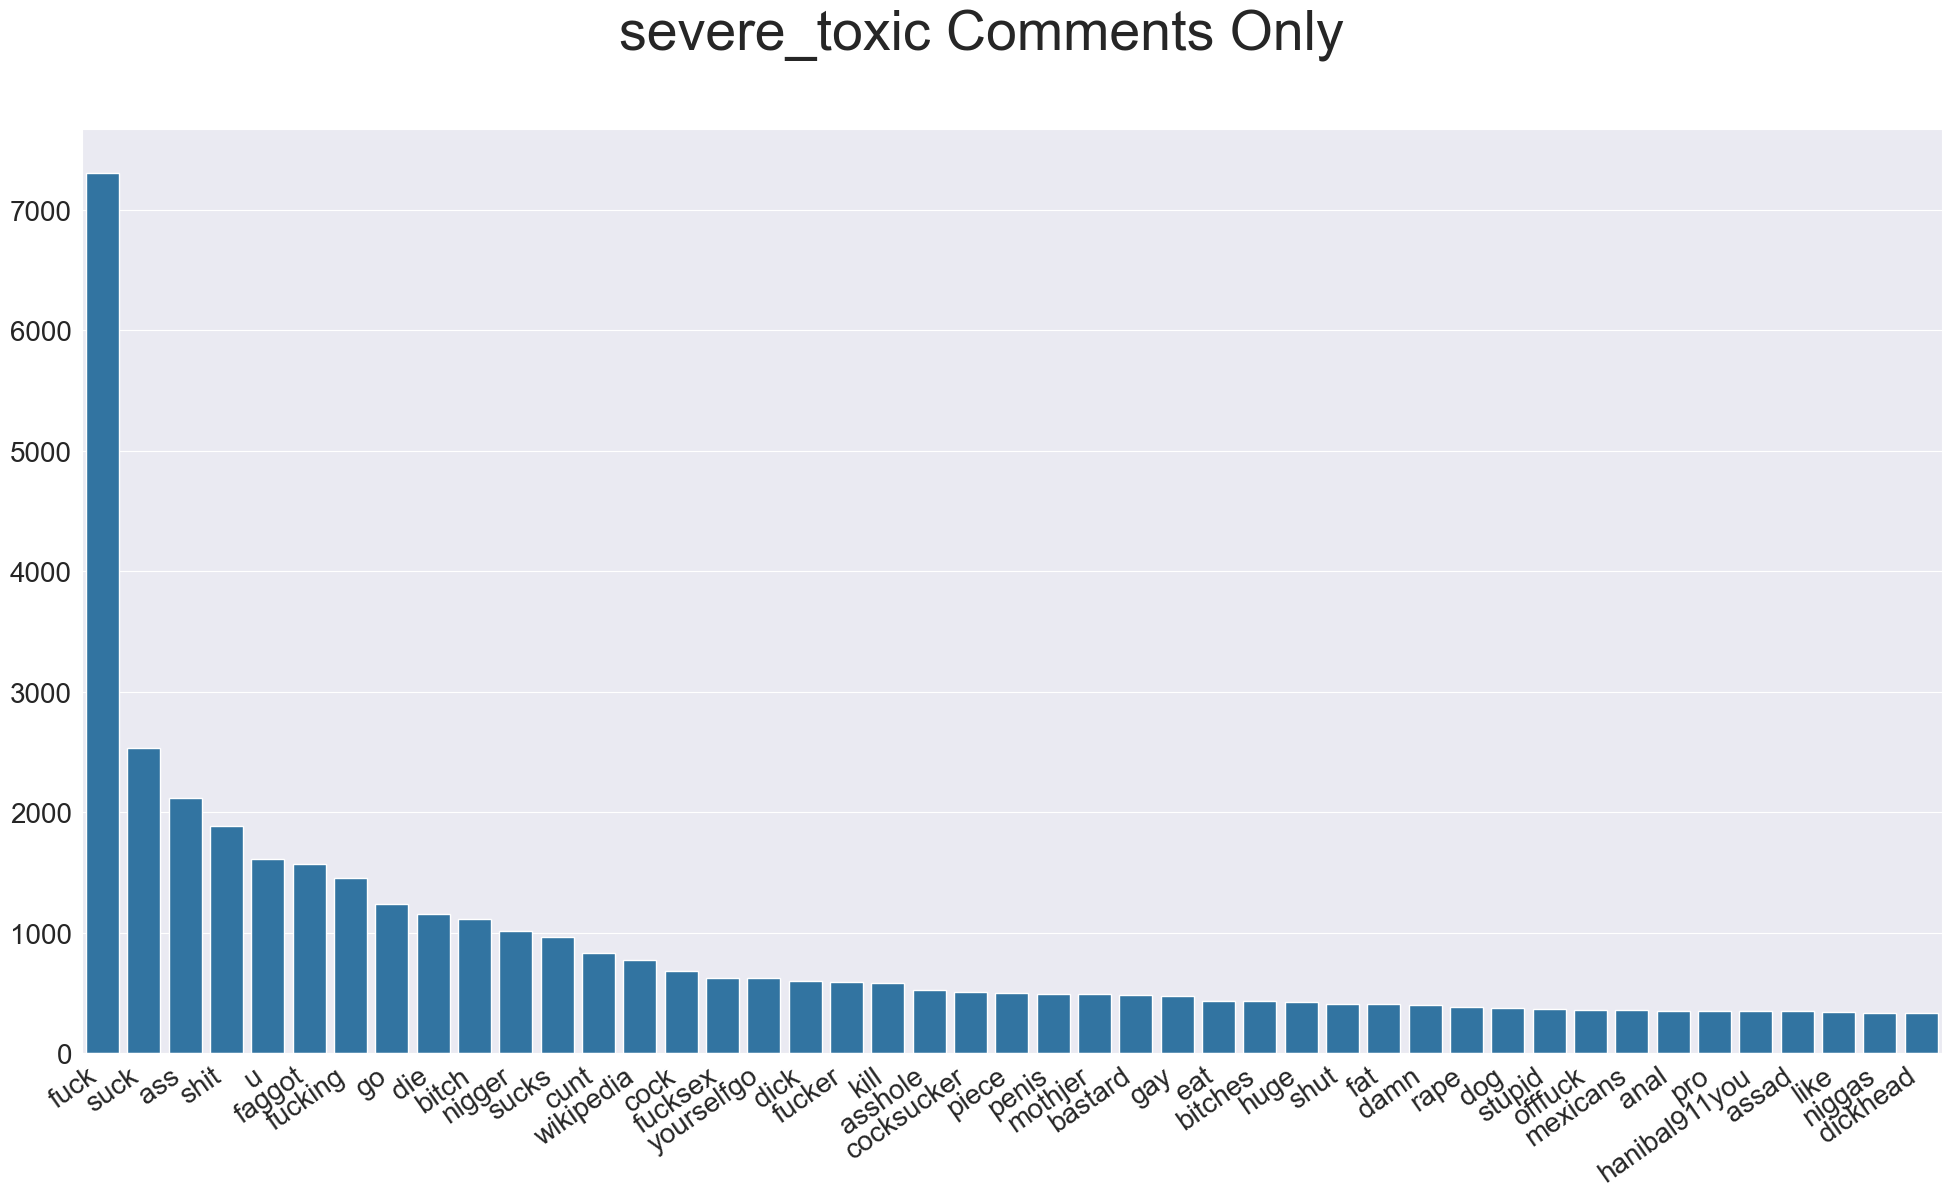

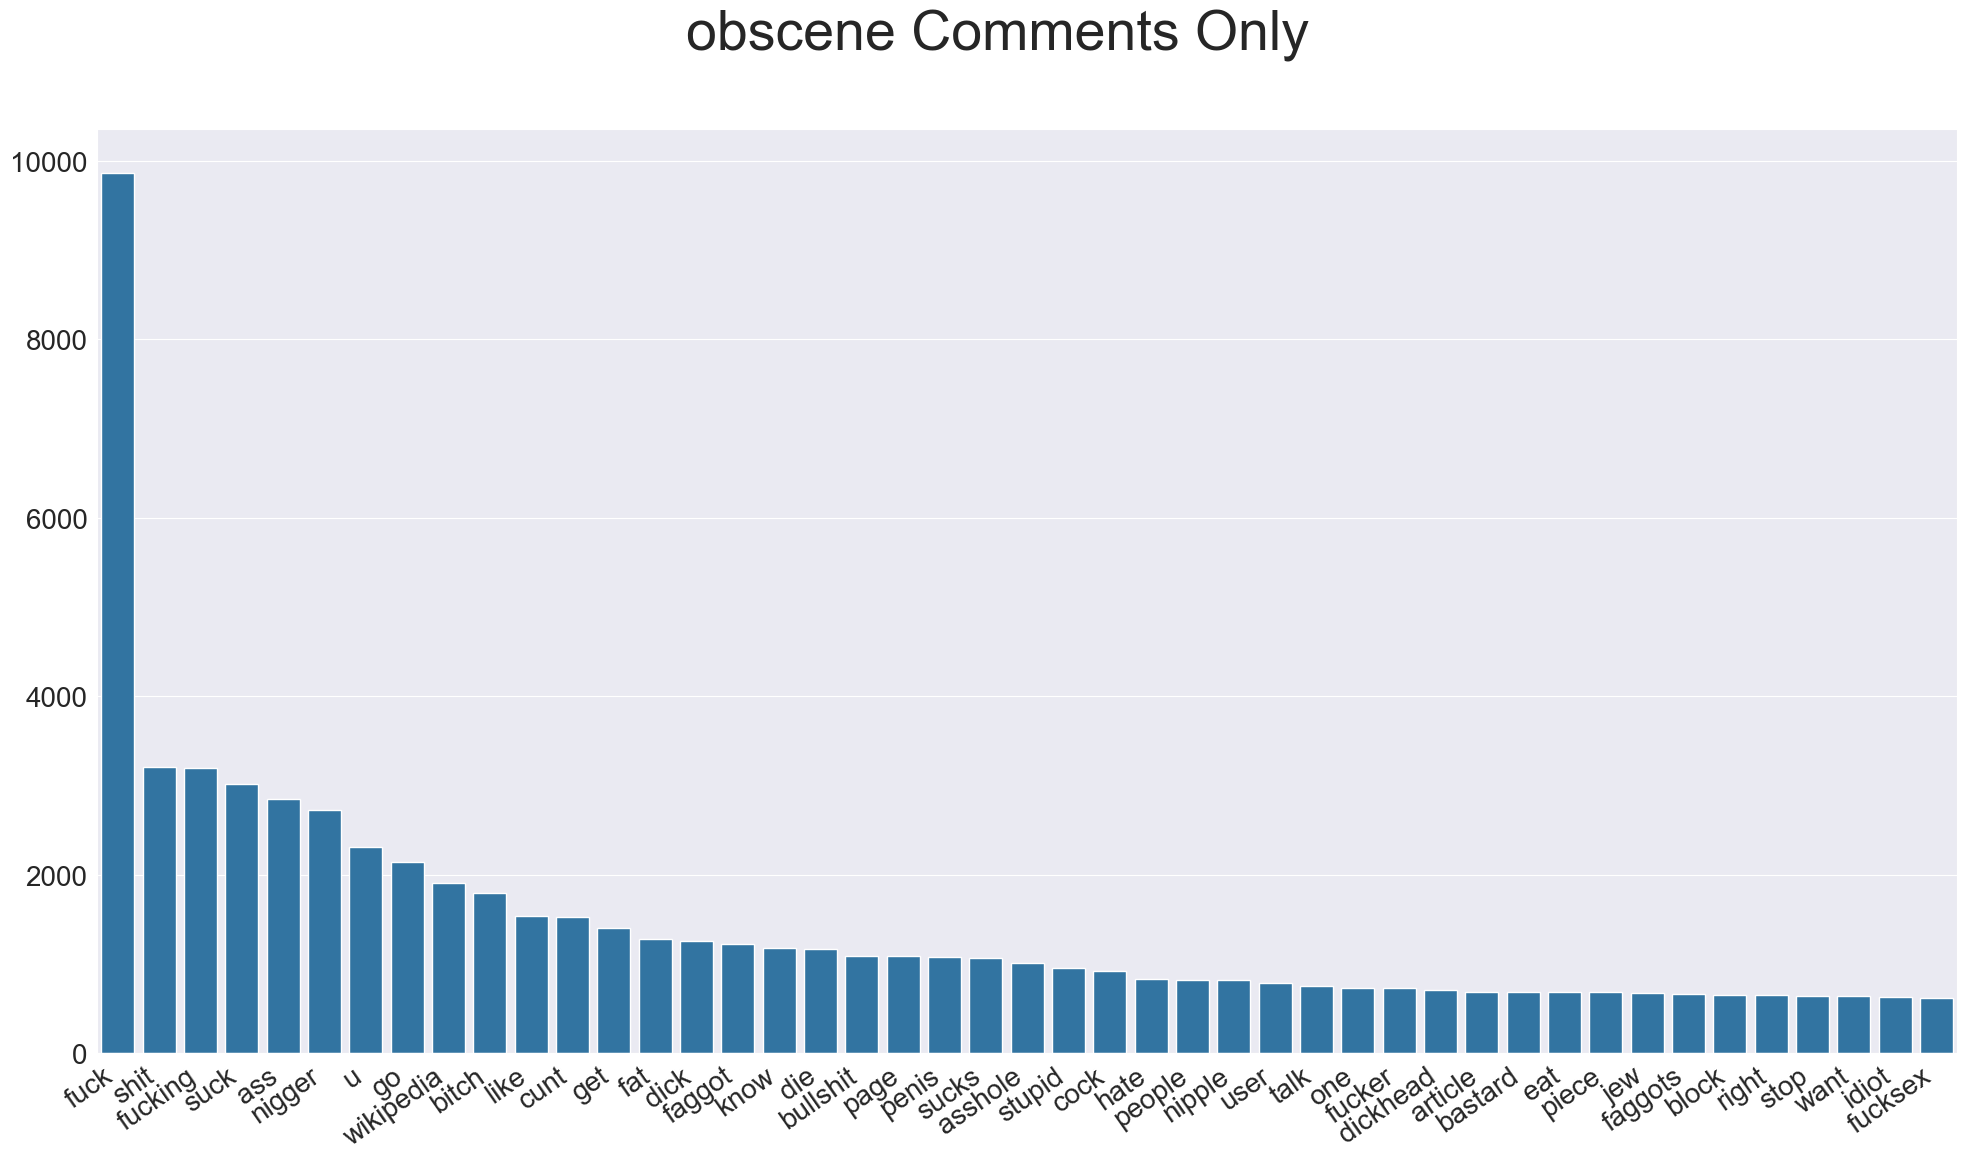

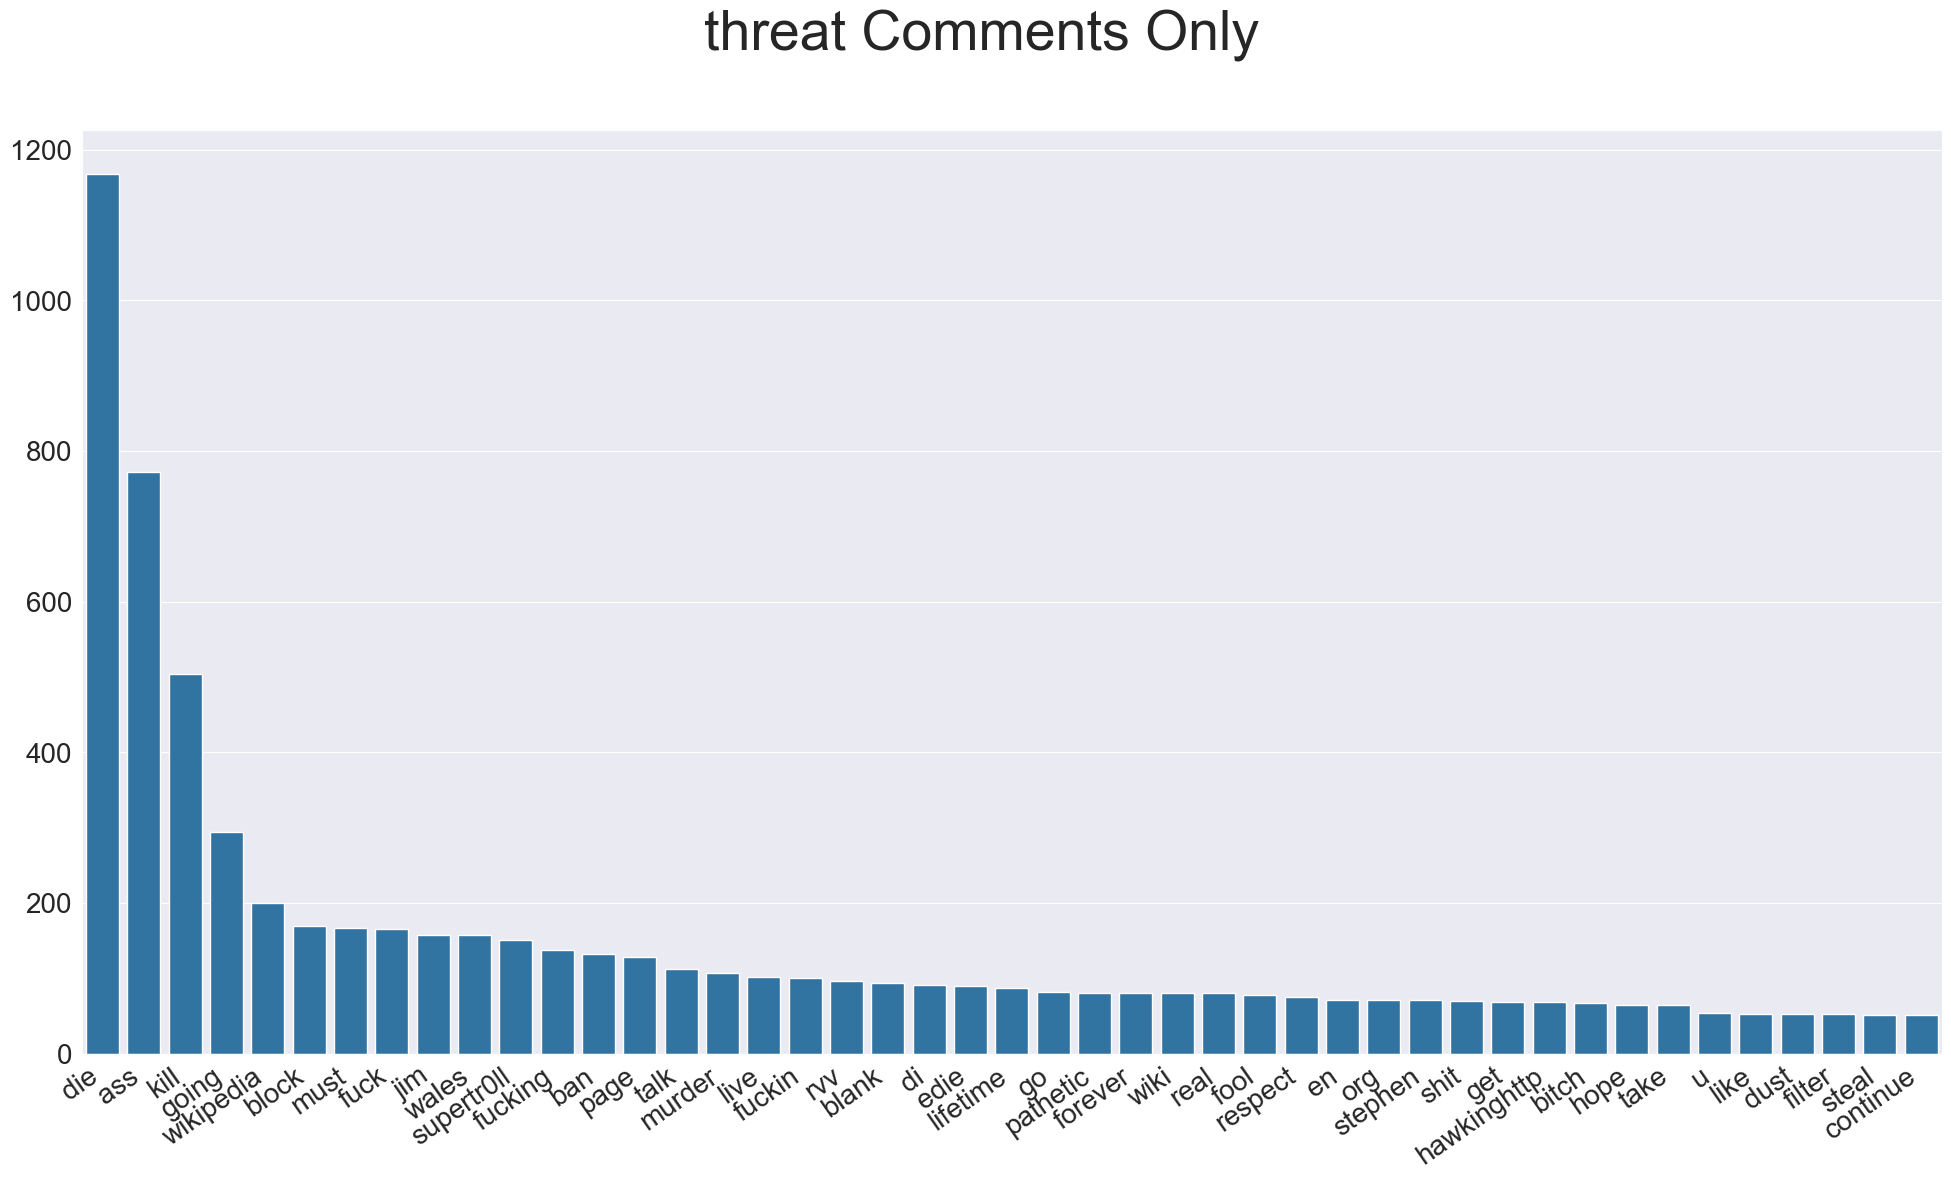

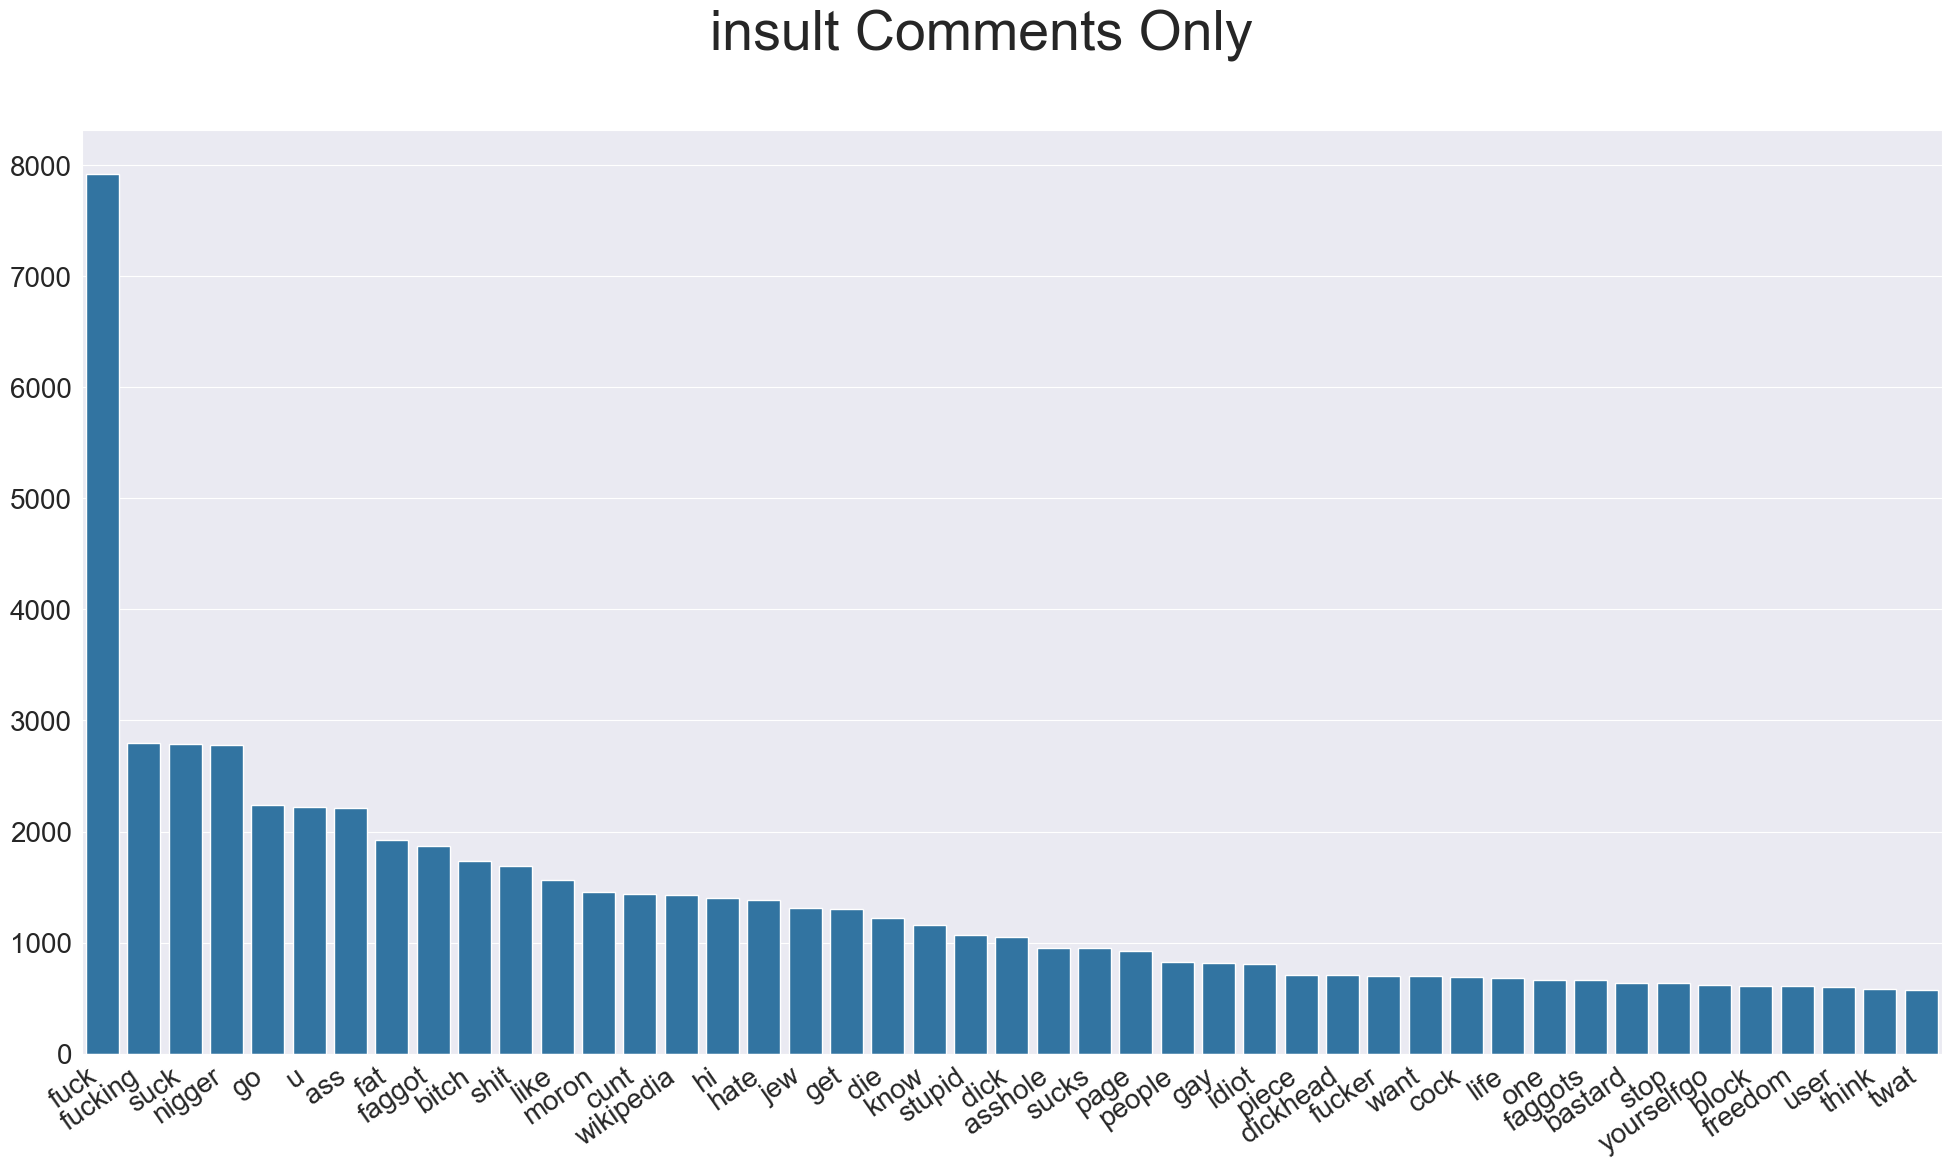

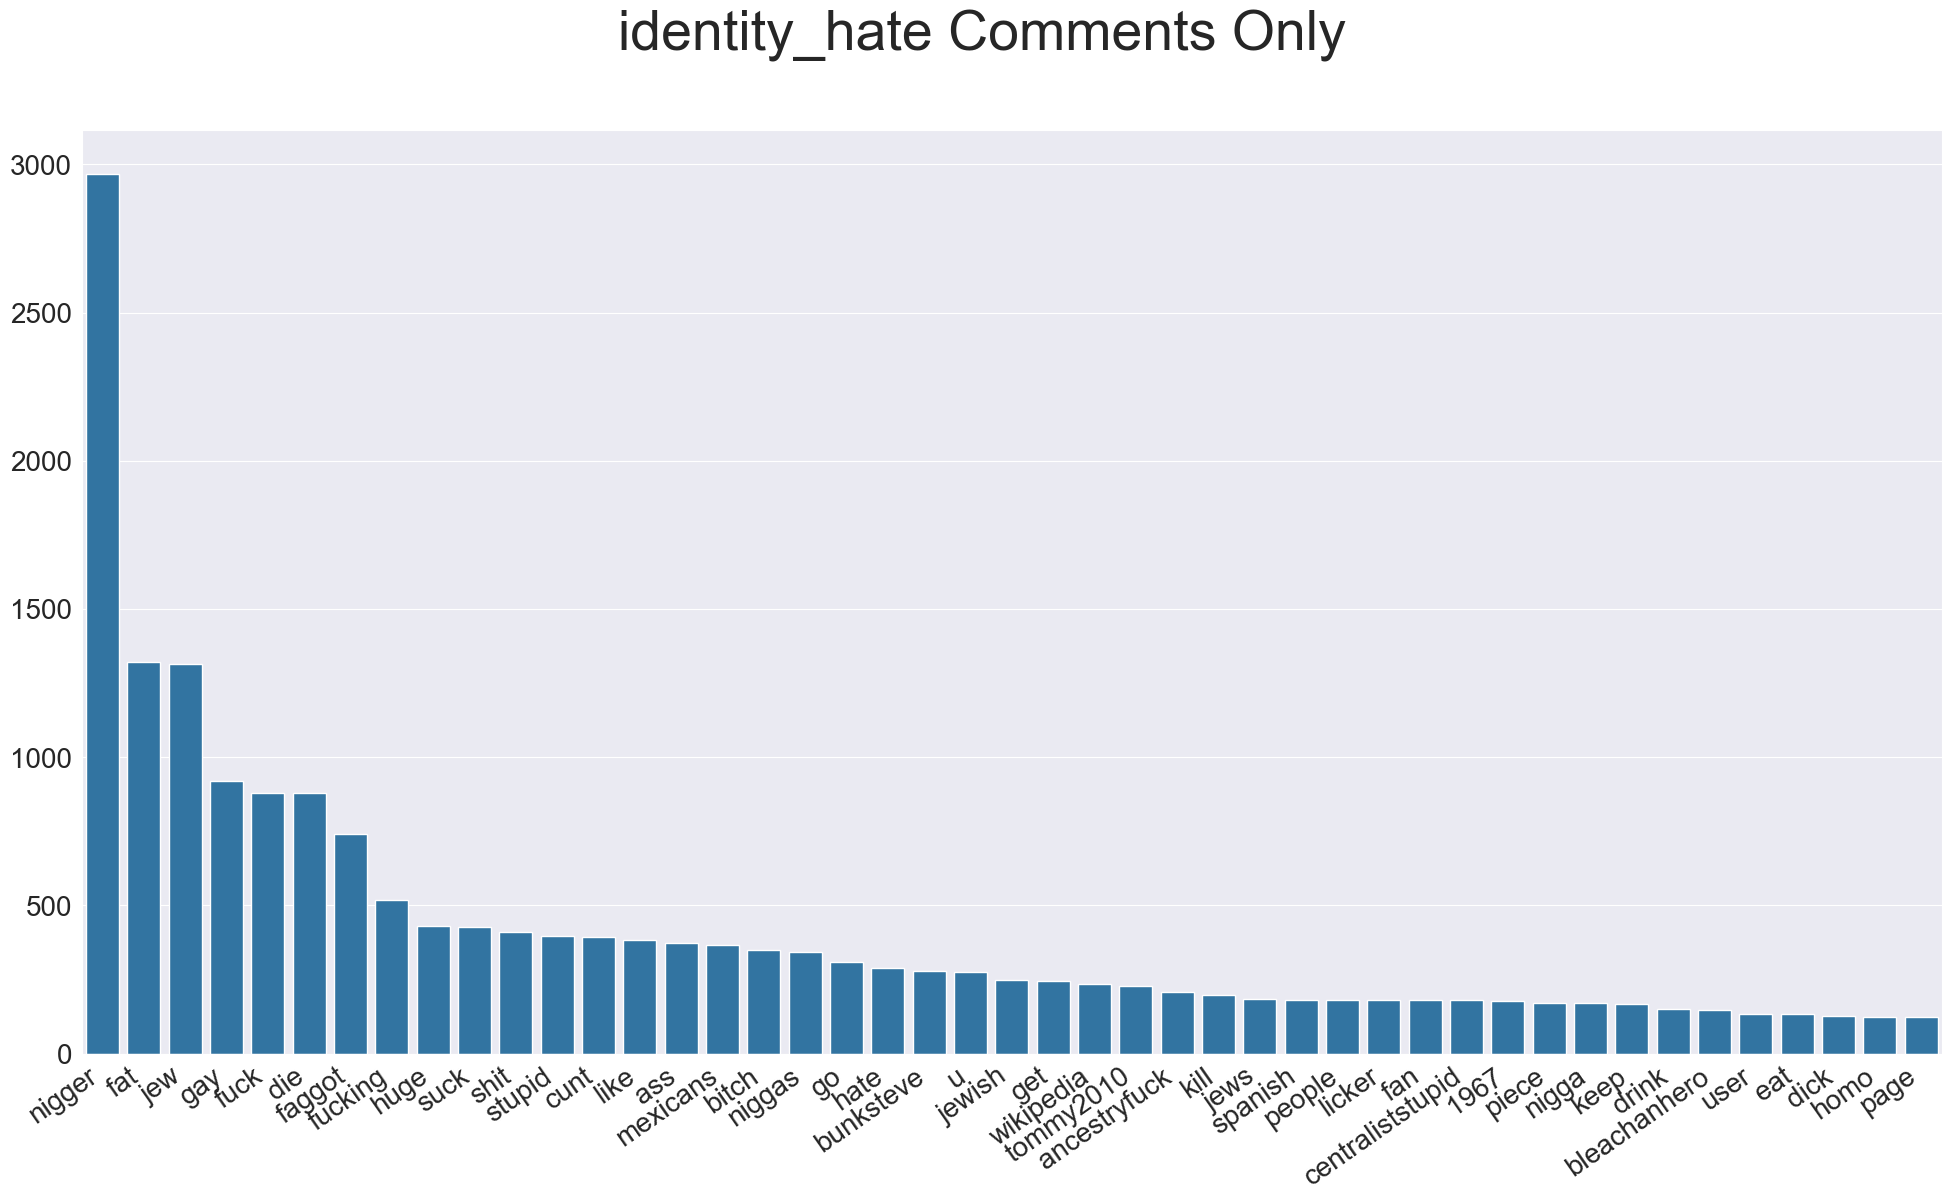

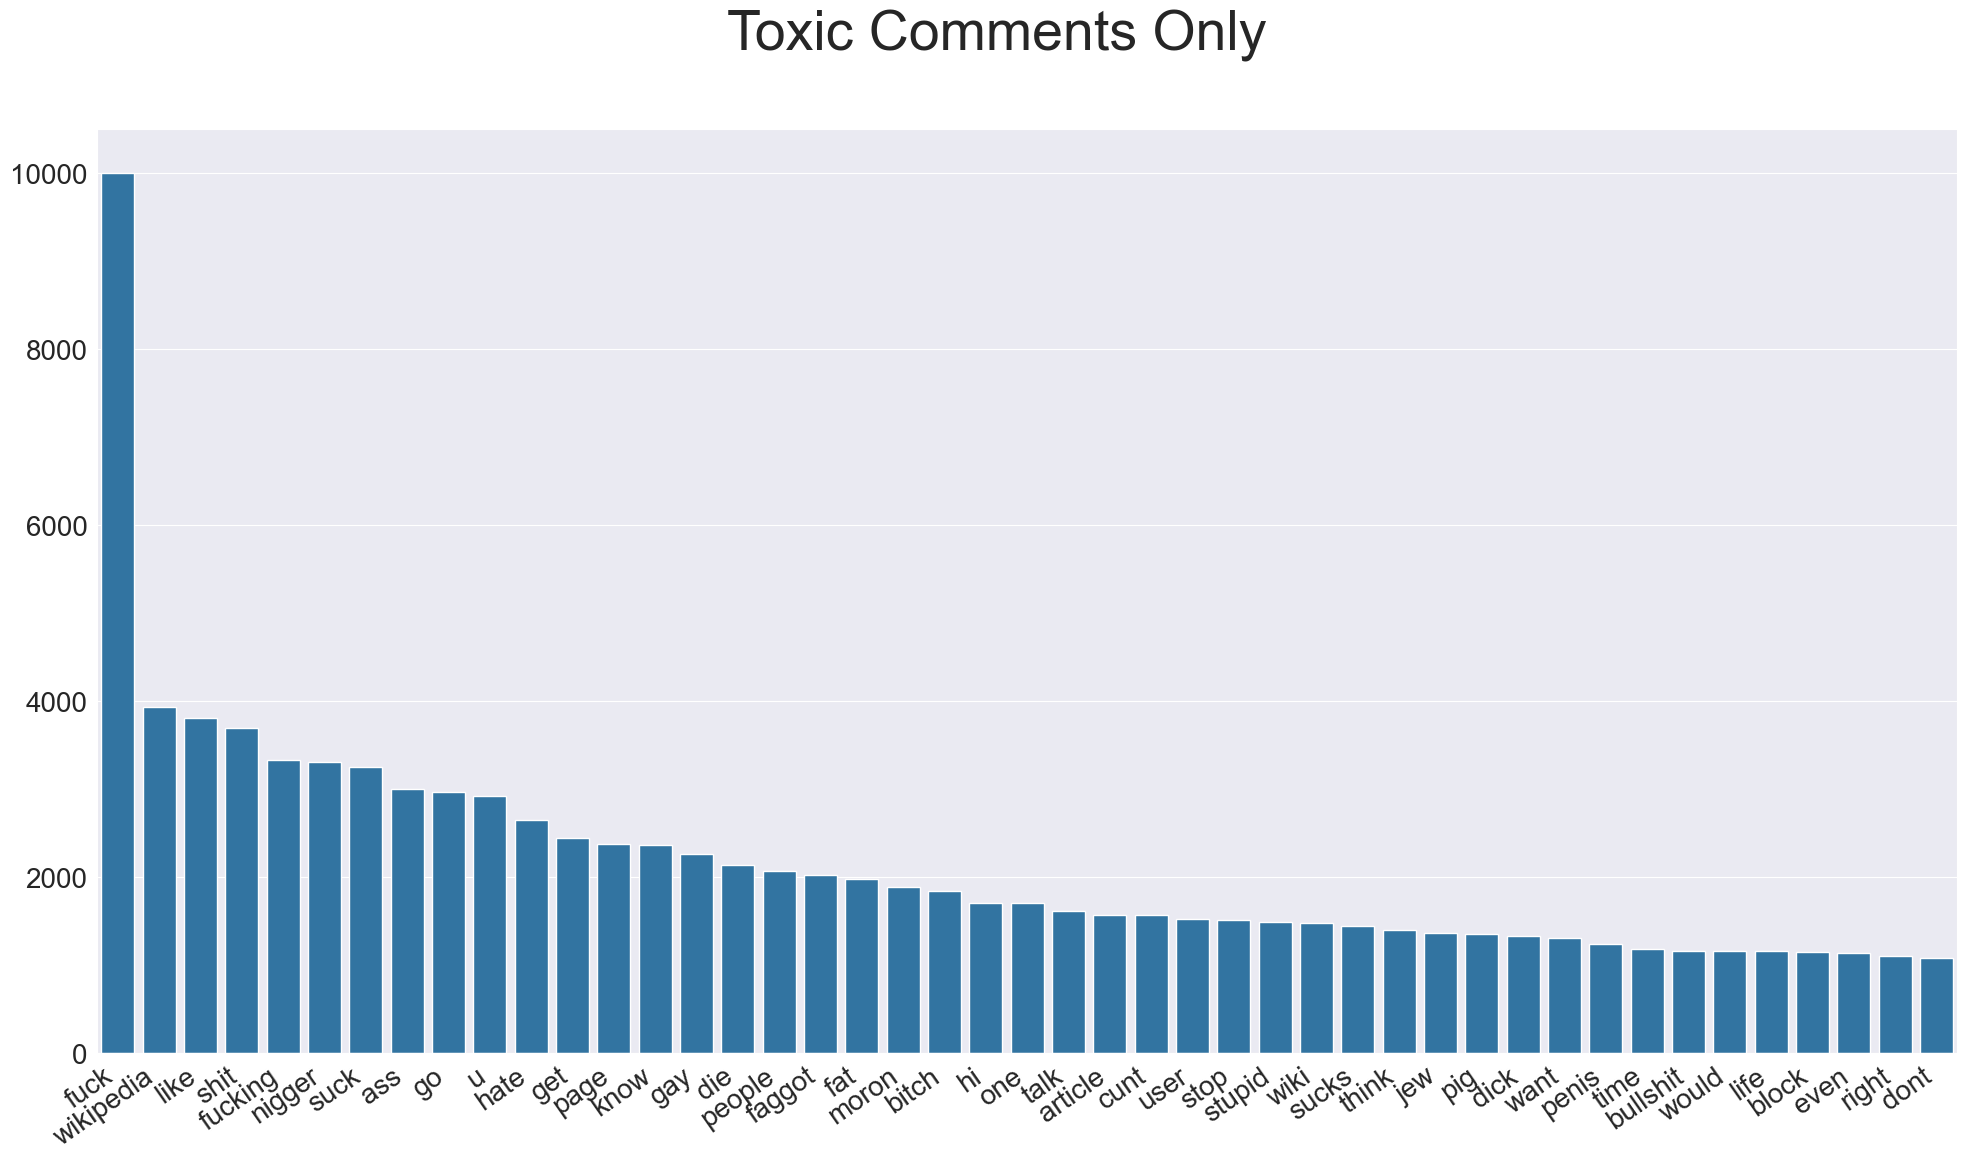

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

targets = list(train.columns[2:])
df_targets = train[targets].copy()

toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)

all_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
all_tokenizer.fit_on_texts(train.comment_text[(toxic_rows==0)])
word_plot(get_word_cnt(all_tokenizer), 45, 'Clean Comments Only')

for label in targets:
    toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
    toxic_tokenizer.fit_on_texts(train.comment_text[(df_targets[label]==1)])
    word_plot(get_word_cnt(toxic_tokenizer), 45, label + ' Comments Only')
    
toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
toxic_tokenizer.fit_on_texts(train.comment_text[toxic_rows])
word_plot(get_word_cnt(toxic_tokenizer), 45, 'Toxic Comments Only')

Biểu đồ trên cho ta thông tin về 45 từ xuất hiện nhiều nhất ứng với mỗi nhãn riêng.

In [22]:
# classify by label

def plot_clusters(X, n_clusters, title):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.title(title)
    plt.show()

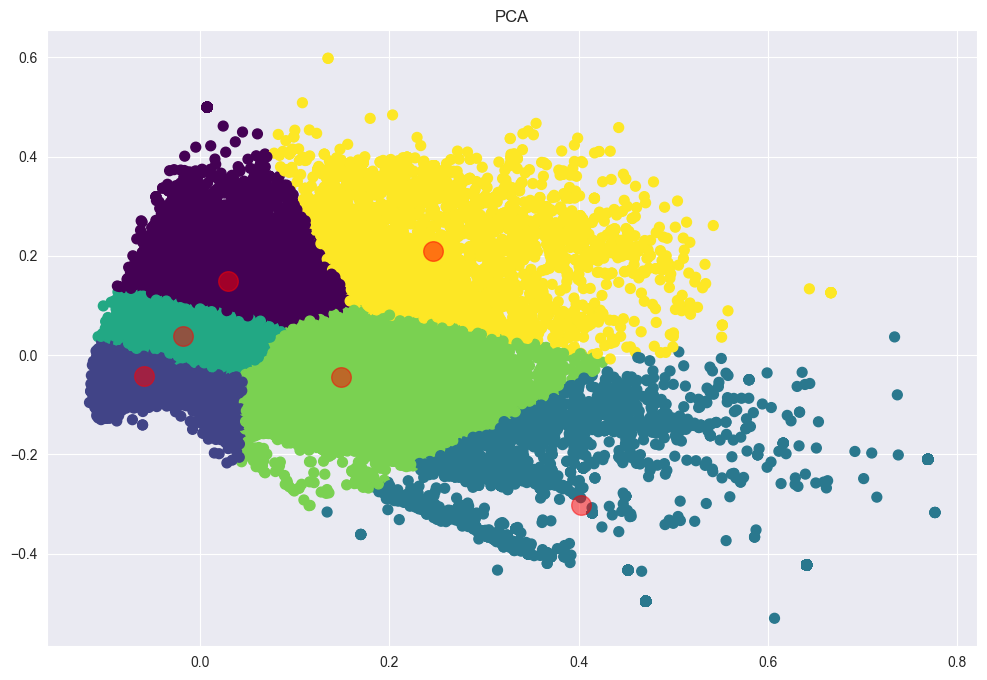

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(train.comment_text)
X = X.toarray()
pca = PCA(n_components=2)
X = pca.fit_transform(X)
plot_clusters(X, 6, 'PCA')